###**Pré-processamentos possiveis**:

- **Normalização**: Normalizar os pixels da imagem;
- **Conversão para escala de cinza**: Como a cor não é uma informação relevante para detecção do gesto, as imagens serão convertidas para escala de cinza;
- **Normalização de iluminação**: Diferentes imagens estao com diferentes níveis de iluminação. Dessa forma, corrigir as variaçoes de iluminação para dar destaque às mãos;
- **Realce**: aplicação de maior contraste nas cores da imagem para aprimorar o facilitar a detecção da posição dedos na frente da palma da mão. Avaliar se aplicar *realce de contraste* ou *equalização de histograma*;
- **Detecção de borda**: Detecção das bordas para mapear o formato exato da mão;
- **Remoção de fundo**: Remover o fundo da imagem para reduzir a complexidade do aprendizado pelo modelo, dada a variabilidade de cores, contraste e iluminação entre as imagens;

###**Ações:**

- **Remoçao de fundo:** Ou aplicar uma máscara e fazer a diferença entre a mascara e imagem original para remover o fundo, ou usando contornos/bordas;
- **Segmentação**: Há imagens em que o antebraço está completamente exposto, enquanto que há imagens em que o antebraço praticamente não aparece. Nesse caso, segmentar apenas a mão é importante;
- **Proximos passos**: Remover o fundo, tirar a média dos pixels e aplicar o realce conforme a média para atingir a média de 150

###**Riscos:**

- Há imagens nas quais uma parte dos dedos são cortados, isso pode prejudicar a leitura da letra pelo modelo;
- O aparecimento do antebraço na imagem pode gerar confusões pelo modelo;

##Download dos dados

In [1]:
pip install opendatasets --upgrade

In [2]:
pip install rembg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 3.1 MB/s eta 0:00:00


In [3]:
from opendatasets import download

download("https://www.kaggle.com/datasets/grassknoted/asl-alphabet")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: matheusvieirabarros
Your Kaggle Key: ··········


100%|██████████| 1.03G/1.03G [00:10<00:00, 106MB/s] 


## Configuração Inicial

Configuração e import de bibliotecas, além da definição da imagem de referência.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from rembg import remove

image_path = 'asl-alphabet/asl_alphabet_train/asl_alphabet_train/S/S87.jpg'
imagem = cv2.imread(image_path)
image_rgb = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

plt.rcParams['axes.grid'] = False  # Desativa as grades nos plots.

## Primeiras Impressões das Imagens

Vamos plotar a imagem de referência para termos a primeira impressão, e a partir disso, realizar o pré-processamento.

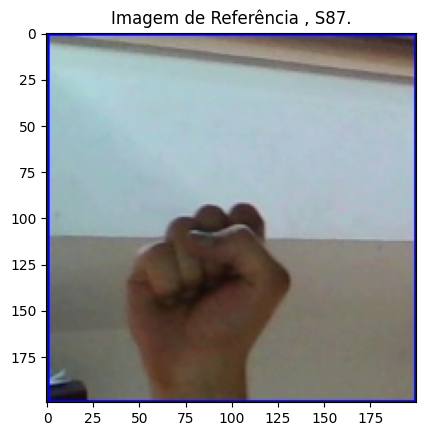

In [11]:
plt.imshow(image_rgb)
plt.title("Imagem de Referência , S87.")
plt.show()

Vamos agora, explorar as propriedades da imagem, como suas dimensões e tipo de encoding.

In [12]:
altura, largura, canais = imagem.shape

propriedades = [
    ('Altura:', altura),
    ('Largura:', largura),
    ('Canais de cor:', canais),
    ('Tipo de dado:', imagem.dtype),
    ('Desvio Padrão', imagem.std())
]

for propriedade, valor_propriedade in propriedades:
    print(f'{propriedade} {valor_propriedade}')


Altura: 200
Largura: 200
Canais de cor: 3
Tipo de dado: uint8
Desvio Padrão 55.45857418040302


Passando para os canais da imagem, vamos usar a função np.asarray(), que irá tabular a imagem em forma numérica, possibilitando a separação de canais.  
Tendo em vista cada canal separado, é possível analisar qual cor possui o maior impacto no elemento desejado da imagem, possibilitando aplicar outras operações.
Abaixo, o código para separação e representação.

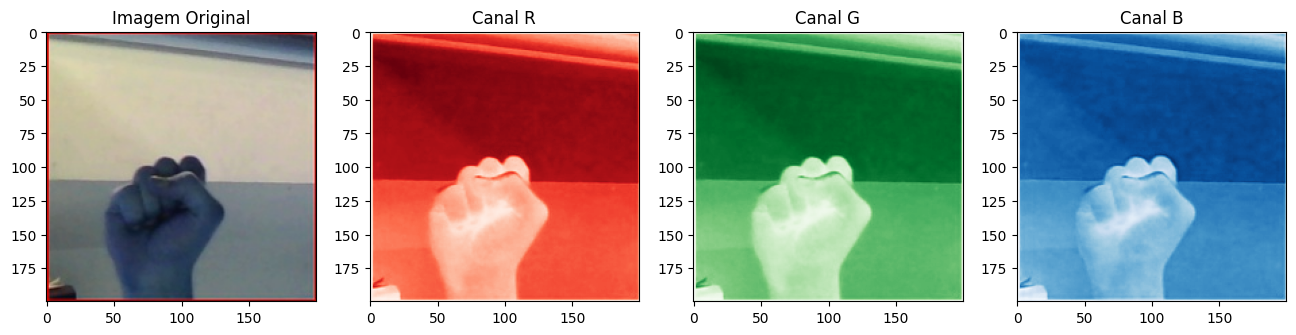

In [13]:
matriz_imagem = np.asarray(imagem)

plt.figure(figsize=(16,8))
plt.subplot(141)

plt.imshow(imagem)
plt.title("Imagem Original")
plt.subplot(142)

plt.imshow(matriz_imagem[:, :, 1], cmap="Reds")
plt.title("Canal R")
plt.subplot(143)

plt.imshow(matriz_imagem[:, :, 1], cmap="Greens")
plt.title("Canal G")
plt.subplot(144)

plt.imshow(matriz_imagem[:, :, 2], cmap="Blues")
plt.title("Canal B")
plt.show()

## Pré-processamento de Imagens

Começaremos por remover o fundo da imagem, para facilitar o processamento.

100%|████████████████████████████████████████| 176M/176M [00:00<00:00, 111GB/s]


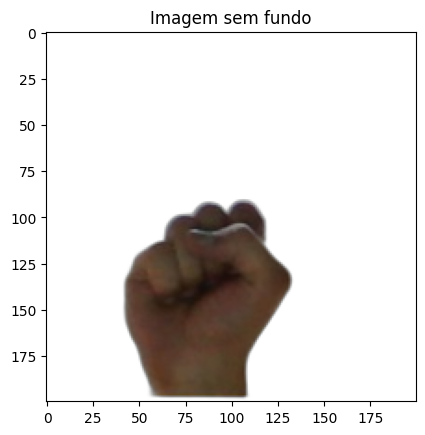

In [14]:
img_sem_fundo = remove(image_rgb)

plt.imshow(img_sem_fundo)
plt.title('Imagem sem fundo')
plt.show()

Como os gestos não são dependentes de cores para serem reconhecidos, mas sim dos formatos, vamos converter a imagem para preto e branco.  
Trabalhar com imagens na escala cinza também reduz o custo computacional para realizar processos nas imagems.

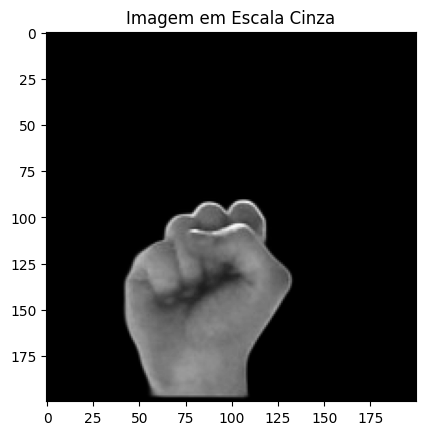

In [18]:
imagem_cinza = cv2.cvtColor(img_sem_fundo, cv2.COLOR_RGB2GRAY)  # Conversão para escala cinza.
plt.imshow(imagem_cinza, cmap="gray")
plt.title("Imagem em Escala Cinza")
plt.show()

Uma vez na escala de cinza, a fim de ajustar o contraste e facilitar a identificaçao das principais características da imagem, aplica-se técnicas de realce.

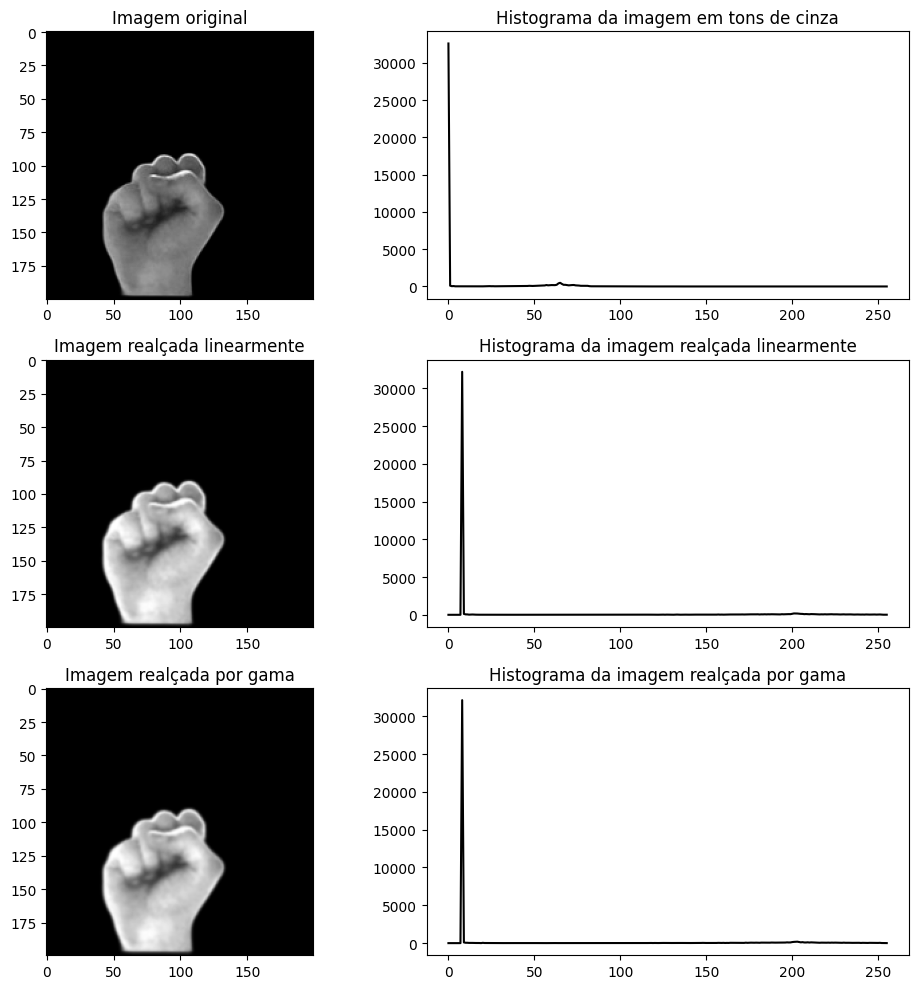

In [103]:
from math import log

#realce por filtro linear
img_equal = cv2.convertScaleAbs(imagem_cinza, alpha = 3, beta = 8)
img_equal = cv2.GaussianBlur(img_equal, (5,5), 0.7, 0.7)

#realce por correção gama:
gamma = 0.8
#img_gamma = np.power(imagem_cinza, gamma).clip(0,255).astype(np.uint8)
img_gamma = (np.power(imagem_cinza/255, gamma)*255).astype(np.uint8)
img_gamma = cv2.GaussianBlur(img_equal, (5,5), 0.5, 0.5)

#obtenção dos histogramas:
hist_cinza = cv2.calcHist([imagem_cinza],[0],None,[256],[0,256])
hist_equal = cv2.calcHist([img_equal],[0],None,[256],[0,256])
hist_gamma = cv2.calcHist([img_gamma],[0], None, [256], [0, 256])

#impressão das imagens
plt.figure(figsize=(10,10))

plt.subplot(3,2,1)
plt.imshow(imagem_cinza, cmap='gray')
plt.title("Imagem original")

plt.subplot(3,2,2)
plt.plot(hist_cinza, color='black')
plt.title('Histograma da imagem em tons de cinza')

plt.subplot(3,2,3)
plt.imshow(img_equal, cmap='gray')
plt.title("Imagem realçada linearmente")

plt.subplot(3,2,4)
plt.plot(hist_equal, color='black')
plt.title('Histograma da imagem realçada linearmente')

plt.subplot(3,2,5)
plt.imshow(img_gamma, cmap='gray')
plt.title('Imagem realçada por gama')

plt.subplot(3,2,6)
plt.plot(hist_gamma, color='black')
plt.title('Histograma da imagem realçada por gama')

plt.tight_layout()
plt.show()

'\nPercebe-se que Canny apresentou um desempenho melhor que Sobel.\n\nAlém disso, para aplicação de Canny, não precisa realizar o realce da imagem. O próprio algoritmo de Canny\nrealiza o calculo dos gradientes aplicando sobel para encontrar as bordas e também aplica um um filtro gaussiano\npara redução de ruído.\n'

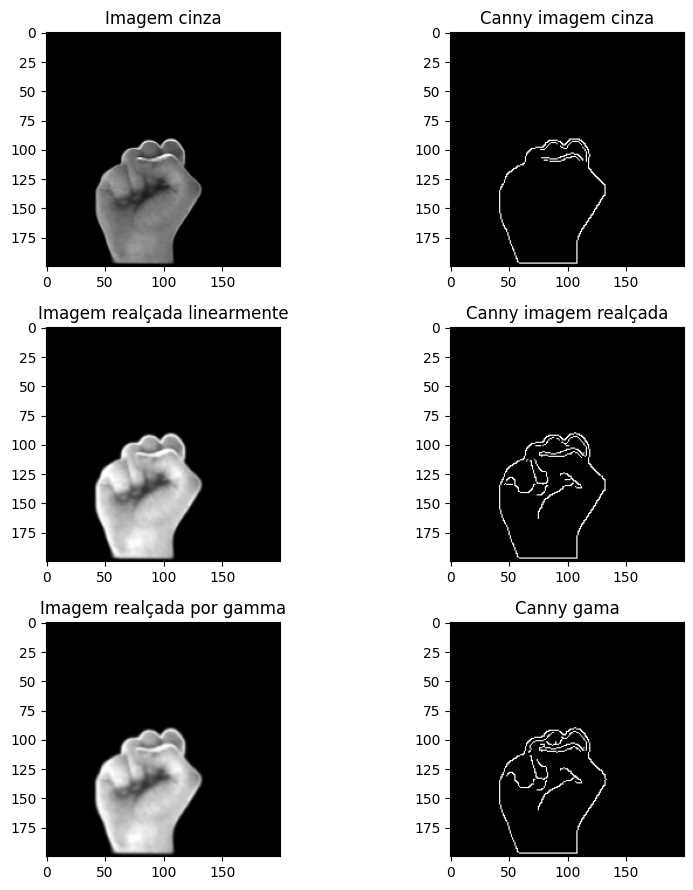

In [104]:
img_canny1 = cv2.Canny(imagem_cinza, threshold1=90,threshold2=200)
img_canny2 = cv2.Canny(img_equal, threshold1=90,threshold2=200)
img_canny3 = cv2.Canny(img_gamma, threshold1=90, threshold2=200)

plt.figure(figsize=(9,9))

plt.subplot(3,2,1)
plt.imshow(imagem_cinza, cmap='gray')
plt.title('Imagem cinza')
plt.subplot(3,2,2)
plt.imshow(img_canny1, cmap='gray')
plt.title('Canny imagem cinza')
plt.subplot(3,2,3)
plt.imshow(img_equal, cmap='gray')
plt.title('Imagem realçada linearmente')
plt.subplot(3,2,4)
plt.imshow(img_canny2, cmap='gray')
plt.title('Canny imagem realçada')
plt.subplot(3,2,5)
plt.imshow(img_gamma, cmap='gray')
plt.title('Imagem realçada por gamma')
plt.subplot(3,2,6)
plt.imshow(img_canny3, cmap='gray')
plt.title('Canny gama')

plt.tight_layout()

"""
Percebe-se que Canny apresentou um desempenho melhor que Sobel.

Além disso, para aplicação de Canny, não precisa realizar o realce da imagem. O próprio algoritmo de Canny
realiza o calculo dos gradientes aplicando sobel para encontrar as bordas e também aplica um um filtro gaussiano
para redução de ruído.
"""

Para processamento da imagem pela rede neural, é importante a normalizaçao de seus pixels.

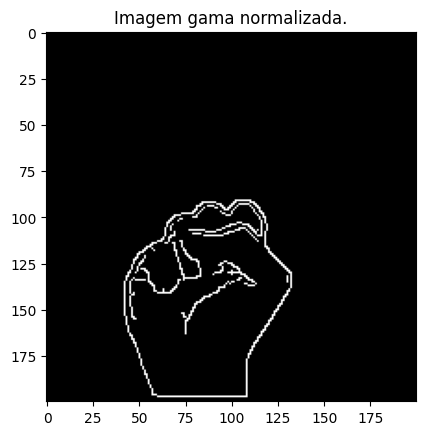

In [100]:
def norma(img):
  return img/255 # normalização dos pixels da imagem

img_norm = norma(img_canny3)

plt.imshow(img_norm, cmap='gray')
plt.title("Imagem gama normalizada.")
plt.show()

##Arquivo

Células arquivadas.

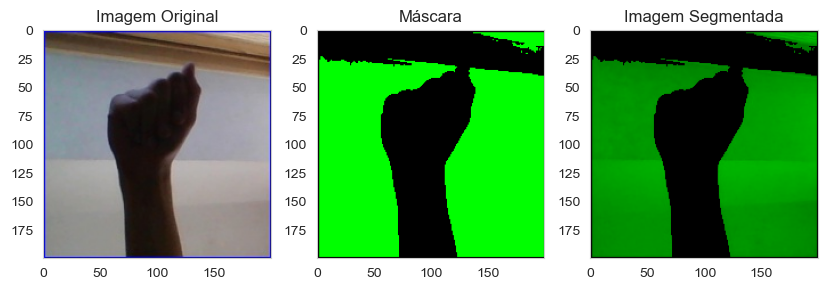

In [ ]:
gray_image = cv2.cvtColor(imagem, cv2.COLOR_BGR2GRAY)
_, binary_image = cv2.threshold(gray_image, 128, 255, cv2.THRESH_BINARY)
contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
mask = np.zeros_like(imagem)
cv2.drawContours(mask, contours, -1, (0, 255, 0), -1)
segmented_image = cv2.bitwise_and(imagem, mask)

plt.figure(figsize=(10, 5))
plt.subplot(131), plt.imshow(imagem[:, :, ::-1]), plt.title('Imagem Original')
plt.subplot(132), plt.imshow(mask[:, :, ::-1]), plt.title('Máscara')
plt.subplot(133), plt.imshow(segmented_image[:, :, ::-1]), plt.title('Imagem Segmentada')
plt.show()

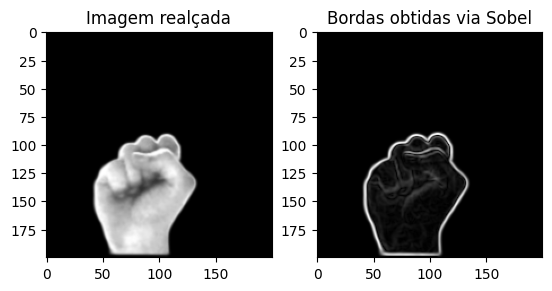

In [23]:
sobel_x = cv2.Sobel(img_equal, cv2.CV_64F, 1, 0, ksize=3, scale = 1, delta = 0)
sobel_y = cv2.Sobel(img_equal, cv2.CV_64F, 0, 1, ksize=3, scale = 1, delta = 0)

gradient_mag = np.sqrt(sobel_x**2 + sobel_y**2)

plt.subplot(1,2,1)
plt.imshow(img_equal, cmap='gray')
plt.title('Imagem realçada')
plt.subplot(1,2,2)
plt.imshow(gradient_mag, cmap='gray')
plt.title('Bordas obtidas via Sobel')

plt.show()